#Import important libraries

In [1]:
import pandas as pd 
import numpy as np 
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models import word2vec
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import os

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load and read the csv file

There are four sections of the papers that have full text. We will read the json file of each section, and create a dataframe that contains the "title","abstract",and "full_text".

In [0]:
#dirs = ['biorxiv_medrxiv','comm_use_subset','custom_license','noncomm_use_subset']

In [0]:
#docs = []
#for d in dirs:
#    for file in os.listdir(f'CORD-19-research-challenge/{d}/{d}'):
#        file_path = f'CORD-19-research-challenge/{d}/{d}/{file}'
#        j = json.load(open(file_path,'rb'))
#        title = j['metadata']['title']
#        
#        abstract = ''
#        for text in j['abstract']:
#            abstract += text['text'] +'\n\n'
#            
#        full_text = ''
#        for text in j['body_text']:
#            full_text += text['text'] +'\n\n'
#
#        docs.append([title,abstract,full_text])
#df = pd.DataFrame(docs,columns = ['title','abstract','full_text'])

After read the json file to a dataframe, we save it to a csv file called df for further analysis. 

In [0]:
#df.to_csv('df.csv', index = False, header=True)

This step read the full text dataframe we just created and named it as df. The words in each column is lowered here. The shape of this dataframe is 33375 rows by 3 columns. 

In [5]:
# load the meta data from the CSV file 
df=pd.read_csv('df.csv')
print (df.shape)

df["abstract"] = df["abstract"].str.lower()
df['title'] = df['title'].str.lower()
df['full_text'] = df['full_text'].str.lower()
#show 10 lines of the new dataframe
print (df.shape)

(33375, 3)
(33375, 3)


In [6]:
df.head(10)

,title,abstract,full_text
0,the rna pseudoknots in foot-and-mouth disease ...,word count: 194 22 text word count: 5168 23 24...,"vp3, and vp0 (which is further processed to vp..."
1,analysis title: regaining perspective on sars-...,"during the past three months, a new coronaviru...","in december 2019, a novel coronavirus, sars-co..."
2,healthcare-resource-adjusted vulnerabilities t...,NaN,the 2019-ncov epidemic has spread across china...
3,"real-time, minion-based, amplicon sequencing f...",infectious bronchitis (ib) causes significant ...,"infectious bronchitis (ib), which is caused by..."
4,a combined evidence approach to prioritize nip...,nipah virus (niv) came into limelight recently...,nipah is an infectious negative-sense single-s...
5,assessing spread risk of wuhan novel coronavir...,background: a novel coronavirus (2019-ncov) em...,"in december 2019, a cluster of patients with p..."
6,"twirls, an automated topic-wise inference meth...",faced with the current large-scale public heal...,the sudden outbreak of the new coronavirus (sa...
7,title: viruses are a dominant driver of protei...,viruses interact with hundreds to thousands of...,the copyright holder for this preprint (which ...
8,the impact of regular school closure on season...,school closure is often considered as an optio...,they affect seasonal influenza dynamics. the m...
9,carbon nanocarriers deliver sirna to intact pl...,post-transcriptional gene silencing (ptgs) is ...,"sirna without relying on plant transformation,..."


Next we will read the matadata csv file that contains around 45000 papers. Some of the papers does not have the full text. We only need the "title" and "abstract" column from this dataframe. 

In [7]:
metadata=pd.read_csv('metadata.csv', usecols=['title','abstract'])
metadata["abstract"] = metadata["abstract"].str.lower()
metadata['title'] = metadata['title'].str.lower()
print(metadata.shape)
metadata.head()

(45774, 2)


,title,abstract
0,siann: strain identification by alignment to n...,next-generation sequencing is increasingly bei...
1,spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...
2,sequencing of the human ig light chain loci fr...,germline variation at immunoglobulin gene (ig)...
3,bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...
4,mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...


Here we merge the two dataframe together. The rows that have the same title from both column will merged, and others will become NaN if there is no match row. 

In [8]:
papers = pd.merge(df, metadata, how = 'left')
papers

,title,abstract,full_text
0,the rna pseudoknots in foot-and-mouth disease ...,word count: 194 22 text word count: 5168 23 24...,"vp3, and vp0 (which is further processed to vp..."
1,analysis title: regaining perspective on sars-...,"during the past three months, a new coronaviru...","in december 2019, a novel coronavirus, sars-co..."
2,healthcare-resource-adjusted vulnerabilities t...,NaN,the 2019-ncov epidemic has spread across china...
3,"real-time, minion-based, amplicon sequencing f...",infectious bronchitis (ib) causes significant ...,"infectious bronchitis (ib), which is caused by..."
4,a combined evidence approach to prioritize nip...,nipah virus (niv) came into limelight recently...,nipah is an infectious negative-sense single-s...
...,...,...,...
52213,understanding human coronavirus hcov-nl63,even though coronavirus infection of humans is...,"regardless of geographic location, respiratory..."
52214,brief definitive report macrophages geneticall...,there is extensive evidence that cultured macr...,experiments were designed to test whether subs...
52215,identification of a subdomain of cenpb that is...,we have combined in vivo and in vitro approach...,"can function in an autonomous fashion, relocat..."
52216,replication enhancer elements within the open ...,we provide experimental evidence of a replicat...,tick-borne encephalitis virus (tbev) is a huma...


In [0]:
papers=papers.dropna()

After dropping the NaN column, we get the final dataframe for analysis.

In [10]:
papers

,title,abstract,full_text
0,the rna pseudoknots in foot-and-mouth disease ...,word count: 194 22 text word count: 5168 23 24...,"vp3, and vp0 (which is further processed to vp..."
1,analysis title: regaining perspective on sars-...,"during the past three months, a new coronaviru...","in december 2019, a novel coronavirus, sars-co..."
3,"real-time, minion-based, amplicon sequencing f...",infectious bronchitis (ib) causes significant ...,"infectious bronchitis (ib), which is caused by..."
4,a combined evidence approach to prioritize nip...,nipah virus (niv) came into limelight recently...,nipah is an infectious negative-sense single-s...
5,assessing spread risk of wuhan novel coronavir...,background: a novel coronavirus (2019-ncov) em...,"in december 2019, a cluster of patients with p..."
...,...,...,...
52213,understanding human coronavirus hcov-nl63,even though coronavirus infection of humans is...,"regardless of geographic location, respiratory..."
52214,brief definitive report macrophages geneticall...,there is extensive evidence that cultured macr...,experiments were designed to test whether subs...
52215,identification of a subdomain of cenpb that is...,we have combined in vivo and in vitro approach...,"can function in an autonomous fashion, relocat..."
52216,replication enhancer elements within the open ...,we provide experimental evidence of a replicat...,tick-borne encephalitis virus (tbev) is a huma...


# Goal
<p>For this project, we get over 45000 biomedical papers as the dataset. This is a very large dataset and it is hard to find valuable information directly from this large dataset. Therefore, I want to build a <b>recommender system</b> that can give recommendations on what papers to read according to a specific query.

# 1. Data Cleaning

By looking at the dataframe metadata.csv, we can see that the dataframe is already in lower cases. Therefore, for the cleaning part, we will remove the following parts:
*  remove stopwords, and add nonrelevent word into the stopwords list in order to remove them
*  remove punctuations such as ":+=%"
*  remove urls from the columns
*  and lemmatize the word in each row 

In [0]:
stop = set(stopwords.words('english'))
stop |= set(['title','abstract','preprint','biorxiv','read','author','funder','copyright','holder','https','license','et','al','may',
             'also','medrxiv','granted','reuse','rights','used','reserved','peer','holder','figure','fig','table','doi','within'])
lemmatizer = WordNetLemmatizer()

In [0]:
def data_preprocessing(text):
    text = ' '.join(re.sub('https?://\S+|www\.\S+','',text).split())
    text = text.replace('\n', '')
    text = re.sub("[!@#$+%*:()/<.=,—']", '', text)
    text = ' '.join([word for word in text.split() if word not in stop])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [0]:
papers['title'] = papers['title'].apply(lambda x: data_preprocessing(x))
papers['abstract'] = papers['abstract'].apply(lambda x: data_preprocessing(x))
papers['full_text'] = papers['full_text'].apply(lambda x: data_preprocessing(x))

In [14]:
papers.reset_index()

,index,title,abstract,full_text
0,0,rna pseudoknots foot-and-mouth disease virus d...,word count 194 22 text word count 5168 23 24 2...,vp3 vp0 processed vp2 vp4 virus assembly 6 p2 ...
1,1,analysis regaining perspective sars-cov-2 mole...,past three month new coronavirus sars-cov-2 ep...,december 2019 novel coronavirus sars-cov-2 ide...
2,3,real-time minion-based amplicon sequencing lin...,infectious bronchitis ib cause significant eco...,infectious bronchitis ib caused infectious bro...
3,4,combined evidence approach prioritize nipah vi...,nipah virus niv came limelight recently due ou...,nipah infectious negative-sense single-strande...
4,5,assessing spread risk wuhan novel coronavirus ...,background novel coronavirus 2019-ncov emerged...,december 2019 cluster patient pneumonia unknow...
...,...,...,...,...
23852,52213,understanding human coronavirus hcov-nl63,even though coronavirus infection human normal...,regardless geographic location respiratory tra...
23853,52214,brief definitive report macrophage genetically...,extensive evidence cultured macrophage genetic...,experiment designed test whether substance ela...
23854,52215,identification subdomain cenpb necessary suffi...,combined vivo vitro approach investigate funct...,function autonomous fashion relocating fused b...
23855,52216,replication enhancer element open reading fram...,provide experimental evidence replication enha...,tick-borne encephalitis virus tbev human patho...


After applying the data_preprecessing function to the "title", "abstract", and "full_text" column, we get our clean text. Each row of the three columns are in lower case, stopwords and punctuations removed, and lemmatized.

# 2. Data Visualization and Exploratory Data Analysis

In this part i will do the data visualization and exploratory data analysis. For my task, my aim is to make recommendations based on a specific query. Therefore, for the EDA, i will take a look at how the data is distributed based on the published year and paper content.

###2.1 Word Cloud
<p>In this section, i will generate a word cloud based on the content in the abstract column, the title column, and the full_text column. The word cloud will return the top frequent words with larger size. This will give us a general idea of what those papers are talking about.

Text(0.5, 1.0, 'Figure 1. Full_text Corpus Word Cloud')

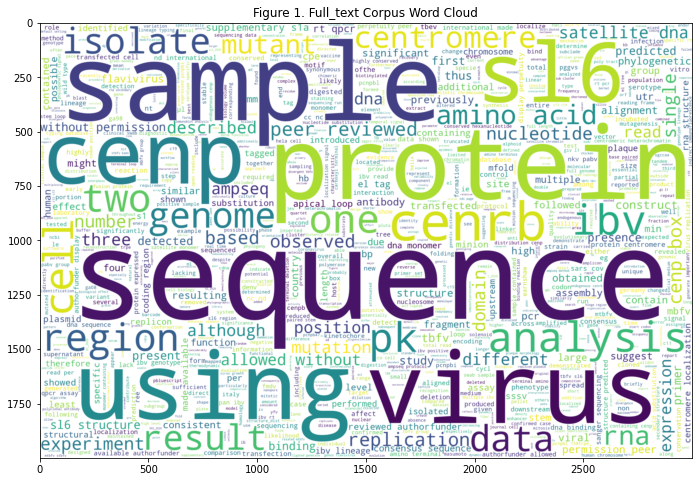

In [15]:
contentCorpus = papers.full_text.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000,height = 2000,background_color="white",max_words=1000).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 1. Full_text Corpus Word Cloud')

Figure 1 is the word cloud generated from the full text column. From this we can see that "sequence","virus","protein","sample" are the most common words among all the body text. This word cloud provide us a general idea of what are the literature's content. We can know that the sequence of the virus, the genetic (protein) of the virus are discussed.

Text(0.5, 1.0, 'Figure 2. Abstract Corpus Word Cloud')

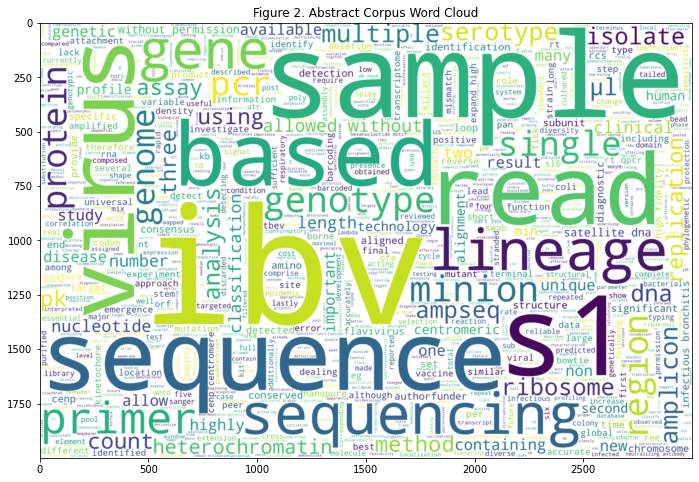

In [16]:
contentCorpus = papers.abstract.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000,height = 2000,background_color="white",max_words=1000).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 2. Abstract Corpus Word Cloud')

From Figure 2, we can see the word cloud generated from the abstract. We can see that the word "ibv", "sequence","virus","sample","dna","isolate" are some of the largest words in the word cloud. Word in abstract can reflect what main idea of the paper. From this, we can also see the word "ibv", which is a type of cornoavirus. We can conclude that the paper is mostly talking about some specific virus and their sequencing and genetic.

Text(0.5, 1.0, 'Figure 3. Title Corpus Word Cloud')

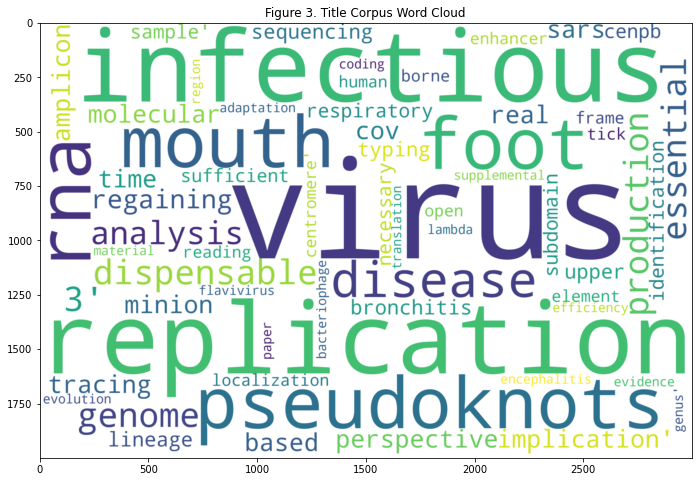

In [17]:
contentCorpus = papers.title.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000,height = 2000,background_color="white",max_words=10000).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 3. Title Corpus Word Cloud')

Figure 3 is the title column's word cloud. "Infections","replications","rna","pseudoknots" are the most common words in the column. These are similar to the above two word cloud. "Foot" and "mouth" are also having large font size, this could indicate that tehre are many papers talking about transmission.

### 2.2 Countplot for different virus discussed among the published papers
<p>From Figure 1,2,and 3 we can have a general idea of what the papers are talking about. In this section, I will categorize the different virus that those paper discussed. By knowing this, we would know how many of them are talking about the covid-19, how many discussed about other virus.
<p>The following code do the virus assignemnt part, I added a column "virs" to record the topic for each paper. I determined the virus of each paper by looking for specific keywords in the full_text. For example, if an article writes about "covis-19" in the full_text, I will assign this paper to topic covid-19.

In [0]:
papers['virus'] = np.where(papers.full_text.str.contains('covid-19|covid|wuhan'), 'covid-19',
              np.where(papers.full_text.str.contains('alphacoronavirus|alpha-cov'), 'alphacoronavirus',
              np.where(papers.full_text.str.contains('betacoronavirus|mers|mers-cov|sars|sars-cov|sars-cov2'), 'betacoronavirus',
              np.where(papers.full_text.str.contains('gammacoronavirus|ibv'), 'gammacoronavirus',
              "None"))))

In [19]:
papers['virus'].value_counts()

betacoronavirus     12245
None                 9664
covid-19              999
alphacoronavirus      528
gammacoronavirus      421
Name: virus, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

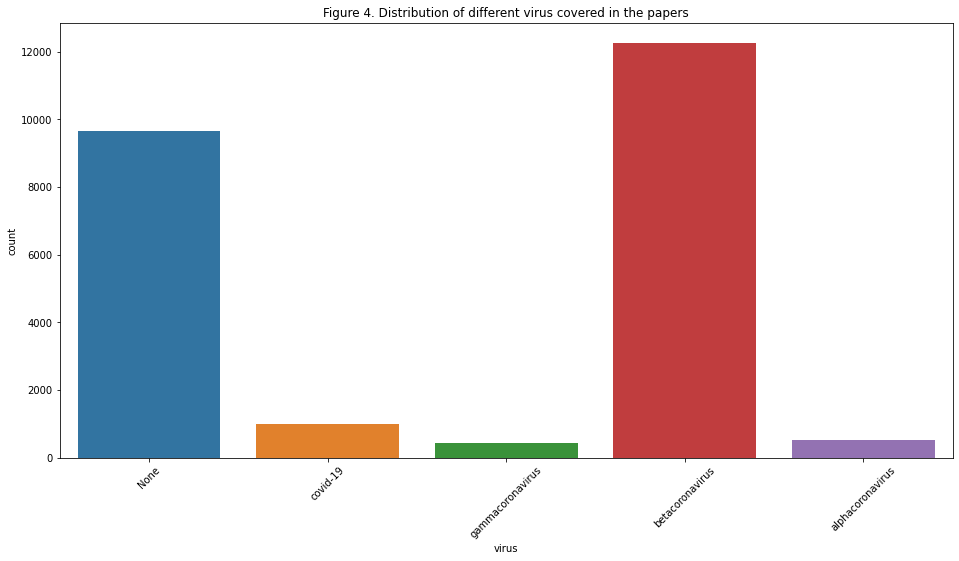

In [20]:
plt.figure(figsize = (16, 8))
ax = sns.countplot(x="virus", data=papers)
ax.set_title('Figure 4. Distribution of different virus covered in the papers')
plt.xticks(rotation=45)

Figure 4 is the visualization of the distribution of differnt virus disscussed among the dataset. As we can see from the figure, the betacoronavirus has the most count. The species in this virus are MERS and SARS which were the two outbreaked dieases. Covid-19 is disscussed a lot too, around 1000 papers mentioned the covid-19 already. Around 400-500 papers are taking about the gamma and alpha coronavirus. 

### 2.3 Distribution of the topic covered in the metadata

From above, we know that around 1000 papers are talking about covid-19 and others are related to other coronaviruses. In this section, we will take a look at the topic covered in those papers. I determined the topic of each paper by looking for specific keywords in the abstract. For example, if an article writes about "transmission" in the abstract, I will assign this paper to topic transmission.
<p>Similar to the above section, the topic column will be added and assigned corrsponding values. After the assignemnt step, i got 7467 papers talking about "genetics|origin|evolution", 2085 papers talking about "transmission", 6469 papers talking about "vaccines|therapeutics", 219 papers talking about "incubation", 788 papers talking about "non-pharmaceutical interventions", 5430 papers taking about "medical care", and 326 papers talking about "ethical|social". Lastly, 2073 papers were not assigned to any topic.

In [0]:
papers['topic'] = np.where(papers.abstract.str.contains('transmission|transmitting'), 'transmission',
              np.where(papers.abstract.str.contains('incubation'), 'incubation',
              np.where(papers.abstract.str.contains('vaccines|vaccine|vaccination|therapeutics|therapeutic|drug|drugs'), 'vaccines|therapeutics',
              np.where(papers.abstract.str.contains('gene|origin|evolution|genetics|genomes|genomic'), 'genetics|origin|evolution',
              np.where(papers.abstract.str.contains('npi|npis|interventions|distancing|isolating|isolation|isolate|mask'), 'non-pharmaceutical interventions',
              np.where(papers.abstract.str.contains('ards|ecmo|respirators|eua|clia|ventilation|cardiomyopathy|ai'), 'medical care',
              np.where(papers.abstract.str.contains('ethical|social|media|rumor|misinformation|ethics|multidisciplinary'), 'ethical|social',
              "None")))))))

In [22]:
papers['topic'].value_counts()

genetics|origin|evolution           7467
vaccines|therapeutics               5469
medical care                        5430
transmission                        2085
None                                2073
non-pharmaceutical interventions     788
ethical|social                       326
incubation                           219
Name: topic, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

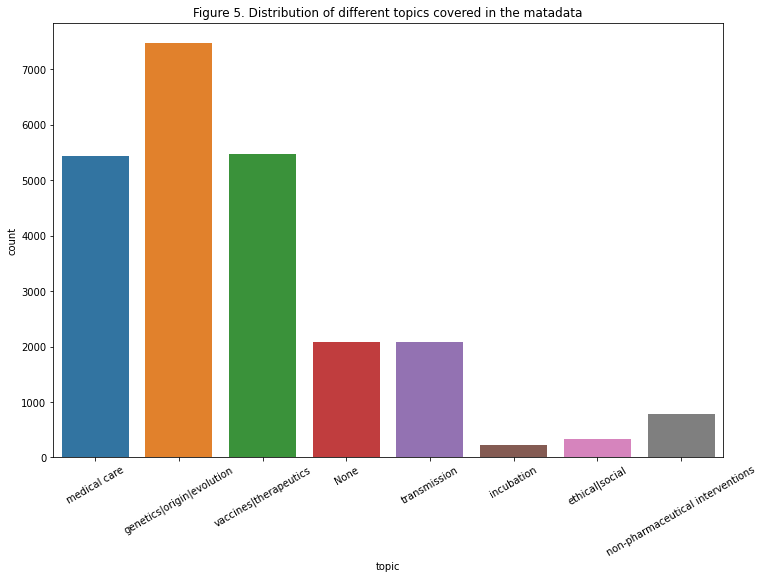

In [23]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="topic", data=papers)
ax.set_title('Figure 5. Distribution of different topics covered in the matadata')
plt.xticks(rotation=30)

From Figure 5, we can see that topic "genetics|origin|evolution" has the most count, followed by "transmission", "vaccines|therapeutics", and "medical care". "transmission", "non-pharmaceutical interventions", "ethical|social", and "incubation" has the least count. 

<b>How could these trends be used to help
with the task of methodically extracting all information and trends of this type?</b>


#3. Model selection and fitting to data

Now, even we have a general idea of what the articals in metadata are talking about, but the quantity is still too large. Researchers will have hard time find the paper or the topic they want to read in this many articles. Therefore, my goal was therefore important. The steps that i will take to achieve my goal is described as follow:
* tokenized the sentense in each row of the "title", "abstract", and "full_text"
* create three new columns called "title_tokenized", "abstract_tokenized", and "full_text_tokenized"
* implement word embedding method (word2vec) as features, here i used joining (averaging) vectors from the words of each sentense. (I used the abstract column to do the training as the full_text would run a really long time and have similar results.)
* append the vectors of each row to a new column called "abstract_embedding", "title_embedding", and "full_text_embedding"
* embedding the qurey phrase to vector form
* calculate the cosine similary between the query vector and each row of the entire abstract embedding column
* append the similarity scores to a new column called "cosine_score"
* sort the column and rank the top 10 paper titles with highest cosine score.




In [0]:
tokenized_sentences_title = [sentence.split() for sentence in papers['title'].values]
tokenized_sentences_abstract = [sentence.split() for sentence in papers['abstract'].values]
tokenized_sentences_full_text = [sentence.split() for sentence in papers['full_text'].values]

In [0]:
papers['title_tokenized'] = tokenized_sentences_title
papers['abstract_tokenized'] = tokenized_sentences_abstract
papers['full_text_tokenized'] = tokenized_sentences_full_text

In [0]:
model = word2vec.Word2Vec(tokenized_sentences_abstract, size = 100, min_count=1)

In [0]:
def embedding_column(df, col_list, model):
    def buildWordVector(word_list, size):
        #function to average all words vectors in a given paragraph
        vec = np.zeros(size)
        count = 0.
        for word in word_list:
            if word in model.wv:
                vec += model.wv[word]
                count += 1.
        if count != 0:
            vec /= count
        return vec

    for col in col_list:
        df[col + "_embedding"] = df[col + "_tokenized"].apply(lambda x: buildWordVector(x, size = 100))  
    return df

papers = embedding_column(papers, ["title", "abstract"], model)

In [28]:
papers.head(10)

,title,abstract,full_text,virus,topic,title_tokenized,abstract_tokenized,full_text_tokenized,title_embedding,abstract_embedding
0,rna pseudoknots foot-and-mouth disease virus d...,word count 194 22 text word count 5168 23 24 2...,vp3 vp0 processed vp2 vp4 virus assembly 6 p2 ...,None,medical care,"[rna, pseudoknots, foot-and-mouth, disease, vi...","[word, count, 194, 22, text, word, count, 5168...","[vp3, vp0, processed, vp2, vp4, virus, assembl...","[0.19333800221128122, -1.0140479441199983, -0....","[0.3080973677446737, 0.022511958525351743, 0.3..."
1,analysis regaining perspective sars-cov-2 mole...,past three month new coronavirus sars-cov-2 ep...,december 2019 novel coronavirus sars-cov-2 ide...,covid-19,genetics|origin|evolution,"[analysis, regaining, perspective, sars-cov-2,...","[past, three, month, new, coronavirus, sars-co...","[december, 2019, novel, coronavirus, sars-cov-...","[-0.06140175302113805, -0.7588521196906056, -0...","[0.14501618871841818, -0.5392360066638348, 0.3..."
3,real-time minion-based amplicon sequencing lin...,infectious bronchitis ib cause significant eco...,infectious bronchitis ib caused infectious bro...,gammacoronavirus,vaccines|therapeutics,"[real-time, minion-based, amplicon, sequencing...","[infectious, bronchitis, ib, cause, significan...","[infectious, bronchitis, ib, caused, infectiou...","[-0.05546940513886511, -1.154684229249445, 0.0...","[0.015282009761039021, -0.6714119372285283, 0...."
4,combined evidence approach prioritize nipah vi...,nipah virus niv came limelight recently due ou...,nipah infectious negative-sense single-strande...,None,vaccines|therapeutics,"[combined, evidence, approach, prioritize, nip...","[nipah, virus, niv, came, limelight, recently,...","[nipah, infectious, negative-sense, single-str...","[-0.4711125466440405, -1.0048149515475546, 0.2...","[-0.1518278659787029, -0.7298661461843226, 0.2..."
5,assessing spread risk wuhan novel coronavirus ...,background novel coronavirus 2019-ncov emerged...,december 2019 cluster patient pneumonia unknow...,covid-19,None,"[assessing, spread, risk, wuhan, novel, corona...","[background, novel, coronavirus, 2019-ncov, em...","[december, 2019, cluster, patient, pneumonia, ...","[-0.3948555929729572, -0.3612390154829392, -0....","[-0.2679716967619382, 0.739074456003996, -0.01..."
6,twirl automated topic-wise inference method ba...,faced current large-scale public health emerge...,sudden outbreak new coronavirus sars-cov-2 end...,covid-19,genetics|origin|evolution,"[twirl, automated, topic-wise, inference, meth...","[faced, current, large-scale, public, health, ...","[sudden, outbreak, new, coronavirus, sars-cov-...","[-0.22946297749876976, -0.38796657982877353, 0...","[0.14561451650742027, -0.6633744553748531, 0.2..."
7,virus dominant driver protein adaptation mammal,virus interact hundred thousand protein mammal...,peer-reviewed authorfunder specialized antivir...,None,genetics|origin|evolution,"[virus, dominant, driver, protein, adaptation,...","[virus, interact, hundred, thousand, protein, ...","[peer-reviewed, authorfunder, specialized, ant...","[0.42666838069756824, -0.03720586374402046, 0....","[0.24989350221585482, -0.545158889789794, 0.74..."
8,impact regular school closure seasonal influen...,school closure often considered option mitigat...,affect seasonal influenza dynamic model applie...,None,transmission,"[impact, regular, school, closure, seasonal, i...","[school, closure, often, considered, option, m...","[affect, seasonal, influenza, dynamic, model, ...","[-0.31471948853383463, -0.4462796980127071, -0...","[-0.2246777902504331, -0.6743058765147764, 0.1..."
9,carbon nanocarriers deliver sirna intact plant...,post-transcriptional gene silencing ptgs power...,sirna without relying plant transformation how...,betacoronavirus,genetics|origin|evolution,"[carbon, nanocarriers, deliver, sirna, intact,...","[post-transcriptional, gene, silencing, ptgs, ...","[sirna, without, relying, plant, transformatio...","[0.6986627

In [0]:
def embedding_query(query):
    query = query.split(' ')
    query_vec = np.zeros(100).reshape((1,100))
    count = 0
    for word in query:
        if word in model.wv:
            query_vec += model.wv[word]
            count += 1.
    if count != 0:
        query_vec /= count
    return query_vec

In [0]:
def calcualte_similarty(query,n_top):
    query_vec = embedding_query(query)
    papers["cos_sim"] = papers['abstract_embedding'].apply(
        lambda x: metrics.pairwise.cosine_similarity(
            [x],query_vec.reshape(1,-1))[0][0])
    top_list = (papers.sort_values("cos_sim", ascending=False)
                [["title","abstract","cos_sim"]]
                .drop_duplicates()[:n_top])
    return top_list

In [31]:
calcualte_similarty('transmission incubation in human ',10)

,title,abstract,cos_sim
25525,stochastic dynamic epidemic recurrent spillove...,emerging human infectious disease animal origi...,0.815781
22330,1 inference forecast h7n9 influenza china,recent emergence ah7n9 avian influenza pose si...,0.812309
949,stochastic dynamic epidemic recurrent spillove...,emerging human infectious disease animal origi...,0.808725
49506,human-livestock contact relationship transmiss...,background micro-organism transmitted vertebra...,0.801520
8472,quantifying seasonal driver transmission lassa...,one contribution 15 theme issue modelling infe...,0.800849
35480,mers emergence novel human coronavirus,novel coronavirus cov cause severe lower respi...,0.797181
5434,primary mode smallpox transmission? implicatio...,mode infection transmission profound implicati...,0.792825
5245,using modelling disentangle relative contribut...,background zoonotic infection transmit animal ...,0.792219
609,mathematical model simulating transmission wuh...,2 study developed bats-hosts-reservoir-people ...,0.790842
5415,article 88 1 original research,nearly 4 year first report emergence middle-ea...,0.788194


# 4. Deriving insights about policy and guidance to tackle the outbreak based on model findings

In the previous section, I created a recommender system with word embedding feature type. The dataset is huge, it contains over 45000 papers and 35000 of them have full text. If the researchers use the dataset directly, it would be a super hard and time spending mission. By the recommender system built in the previous section, researchers could just providing a specific query, or a paper title. Then the model will calculate the cosine similarity between the query and the dataset and return the top 10 or 20 similar papers for researchers to read. This indeed minimize their time and would be benefit for fighting against the COVID-19.
<p>Next, I will run following querys related to the COVID-19 as some examples:

* Risk factors of the novel coronavirus 2019
* covid-19 genetics, origin, or evolution 
* Drugs or medicines to treat COVID-19 patients


By running the above queries, we get our top 10 recommendation. (The result is shown below)
<p>For the first query, "The risk factors of covid-19", we get pretty great recommendations on the paper. We can see many of the recommendated papers contain "risk" and we can see that they described differnt kinds of risk factors. For researchers, governments, and healthcare professionals who are interested in reading the risk factors of the novel cornoavirus, i would suggest them reading the above articles. 
<p>For the second query, it asks about the genetics, origins, or evolutions of the covid-19. The results are also satisfying, as we can see the recommendated papers are about the genetic diversity, about the virus evolution. Therefore, if researchers want to find out the potential genetics, origins or evolution of the novel virus, I would recommend them reading those papers.
<p>For the third query, it is about drugs or medicines to treat covid-19 patients. The returned recommended papers are very good as well. We can see some of the papers recommend chinese medicine. Thus, for healthcare professionals or the public heath department, if they need any information of the drug and medicine to treat patients, I would highly recommend them to read the above paper. 
<p>To conclude, there are over 45000 papers related to the new coronavirus, it would be a waste of time for the researchers to go through them one by one. A recommender system like this notebook did would save a lot of time. This would be a very fast way for researchers, governments, healthcare professionals to find more information about a similar, relevant material. 

In [32]:
calcualte_similarty('risk covid-19',10)

,title,abstract,cos_sim
516,estimating risk covid-19 infection adult chemo...,sars-cov-2 covid-19 novel corona virus represe...,0.836613
89,perception adult u population regarding novel ...,background covid-19 outbreak spreading globall...,0.832348
228,active latent tuberculosis increase susceptibi...,sars-cov-2 infection patient active latent tb ...,0.818974
4246,real-time characterization risk death associat...,background outbreak middle east respiratory sy...,0.815966
37609,human infection avian infl uenza h7n9 virus as...,background characterisation severity profi le ...,0.812544
3130,risk cross infection emergency department simu...,objective risk cross infection busy emergency ...,0.811526
46585,middle east respiratory syndrome risk percepti...,2015 middle east respiratory syndrome mers out...,0.810492
10842,identify-isolate-inform modified tool initial ...,middle east respiratory syndrome mers novel in...,0.808873
18831,nursing care patient severe acute respiratory ...,severe acute respiratory syndrome sars diagnos...,0.807609
26583,institution involved food safety world health ...,hazard biological chemical physical agent prop...,0.806316


In [33]:
calcualte_similarty('covid-19 genetics origin evolution',10)

,title,abstract,cos_sim
2736,full-genome characterization genetic evolution...,bagaza virus mosquito-borne flavivirus first i...,0.876592
42229,genetic diversity evolution sars-cov-2,covid-19 viral respiratory illness caused new ...,0.865751
232,mers-cov recombination implication reservoir p...,recombination process unlinks neighbouring loc...,0.865061
50848,mers-cov recombination implication reservoir p...,recombination process unlinks neighboring locu...,0.863831
4357,emerging concept data integration pathogen phy...,phylodynamics become increasingly popular stat...,0.862723
52003,global pattern coronavirus diversity,since emergence severe acute respiratory syndr...,0.861432
38805,evolution population genomics lyme borreliosis...,population genomic study potential address man...,0.860742
428,emergent clade sars-cov-2 linked returned trav...,sars-cov-2 epidemic rapidly spread outside chi...,0.858887
15081,evolution ebola virus insight 2013-2016 epidemic,2013-2016 epidemic ebola virus disease west af...,0.857952
5292,phylodynamic application 21 st century global ...,background phylodynamics study interaction epi...,0.856109


In [34]:
calcualte_similarty('drugs medicine to treat covid-19 patients',10)

,title,abstract,cos_sim
49042,potential contribution traditional chinese med...,background despite fact traditional chinese me...,0.803923
11339,review article current situation perspective c...,integrative medicine innovative china model cl...,0.784752
20445,402 journal integrative medicine,traditional chinese medicine tcm commonly trea...,0.772063
18460,journal pre-proof understanding guidance acupu...,"china model"" acupuncture moxibustion tradition...",0.769090
42776,travel medicine infectious disease xxx xxxx xxxx,travel medicine infectious disease xxx xxxx xx...,0.763579
17745,traditional chinese medicine treatment upper r...,introduction traditional chinese medicine tcm ...,0.762053
49290,evidence-based practice cancer care asia-pacifi c,cancer burden global problem oncology nurse ac...,0.761646
50563,world journal clinical case case report 222 du...,minireviews complementary examination neuroima...,0.758917
1868,district health office ministry health,bronchiolitis common cause hospitalization amo...,0.756612
12824,update emerging infection news center disease ...,editor note article part regular series emergi...,0.753298
